In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 196

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [4]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
#         return {'regressor_out':y_regr}
        return y_class
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [5]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

# history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
#                     validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
#                     epochs=50, batch_size=32)
history = model.fit(x_train_split, x_train_)

# model.encoder.save_weights('../weights/42_CAE2x16_enc_epoch50_weights.h5')
# model.decoder.save_weights('../weights/42_CAE2x16_dec_epoch50_weights.h5')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_out_loss'])
plt.plot(history.history['val_decoder_out_loss'])
plt.title('16-Split training')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
# plt.savefig('../img/47_PLOTS/16split_latent2_reco_loss.png', dpi=200)

Epoch 1/50
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0283 - classifier_out_loss: 2.4115 - decoder_out_loss: 0.0283 - regressor_out_loss: 98.8187 - classifier_out_accuracy: 0.1044 - decoder_out_accuracy: 0.9521 - regressor_out_accuracy: 0.5174 - val_loss: 0.0285 - val_classifier_out_loss: 2.4147 - val_decoder_out_loss: 0.0285 - val_regressor_out_loss: 98.8226 - val_classifier_out_accuracy: 0.1028 - val_decoder_out_accuracy: 0.9518 - val_regressor_out_accuracy: 0.5160
Epoch 2/50
1771/1875 [===========================>..] - ETA: 1s - loss: 0.0278 - classifier_out_loss: 2.4114 - decoder_out_loss: 0.0278 - regressor_out_loss: 98.8257 - classifier_out_accuracy: 0.1039 - decoder_out_accuracy: 0.9522 - regressor_out_accuracy: 0.51

KeyboardInterrupt: 

2. latent space of 8*128

In [2]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 8

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0148 - classifier_out_loss: 2.3329 - decoder_out_loss: 0.0148 - regressor_out_loss: 100.0004 - classifier_out_accuracy: 0.1002 - decoder_out_accuracy: 0.9511 - regressor_out_accuracy: 0.5139 - val_loss: 0.0062 - val_classifier_out_loss: 2.3087 - val_decoder_out_loss: 0.0062 - val_regressor_out_loss: 99.9772 - val_classifier_out_accuracy: 0.0965 - val_decoder_out_accuracy: 0.9507 - val_regressor_out_accuracy: 0.5198
Epoch 2/50
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0055 - classifier_out_loss: 2.3087 - decoder_out_loss: 0.0055 - regressor_out_loss: 99.9798 - classifier_out_accuracy: 0.0992 - decoder_out_accuracy: 0.9517 - regressor_out_accuracy: 0.5149 - val_loss: 0.0049 - val_classifier_out_loss: 2.3095 - val_decoder_out_loss: 0.0049 - val_regressor_out_loss: 99.9820 - val_classifier_out_accuracy: 0.0980 - val_decoder_out_accuracy: 0.9518 - val_regressor_out_accuracy: 0.5214
Epo

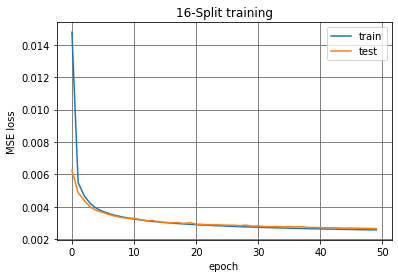

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

model.encoder.save_weights('../weights/42_CAE8x16_enc_epoch50_weights.h5')
model.decoder.save_weights('../weights/42_CAE8x16_dec_epoch50_weights.h5')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_out_loss'])
plt.plot(history.history['val_decoder_out_loss'])
plt.title('16-Split training')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.savefig('../img/47_PLOTS/16split_latent8_reco_loss.png', dpi=200)

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 1

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/50
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0230 - classifier_out_loss: 2.3097 - decoder_out_loss: 0.0230 - regressor_out_loss: 99.5547 - classifier_out_accuracy: 0.1021 - decoder_out_accuracy: 0.9522 - regressor_out_accuracy: 0.3721 - val_loss: 0.0157 - val_classifier_out_loss: 2.3032 - val_decoder_out_loss: 0.0157 - val_regressor_out_loss: 99.7316 - val_classifier_out_accuracy: 0.1008 - val_decoder_out_accuracy: 0.9518 - val_regressor_out_accuracy: 0.2598
Epoch 2/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0153 - classifier_out_loss: 2.3029 - decoder_out_loss: 0.0153 - regressor_out_loss: 99.7431 - classifier_out_accuracy: 0.1016 - decoder_out_accuracy: 0.9521 - regressor_out_accuracy: 0.2542 - val_loss: 0.0151 - val_classifier_out_loss: 2.3032 - val_decoder_out_loss: 0.0151 - val_regressor_out_loss: 99.7439 - val_classifier_out_accuracy: 0.1007 - val_decoder_out_accuracy: 0.9510 - val_regressor_out_accuracy: 0.2558
Epoc

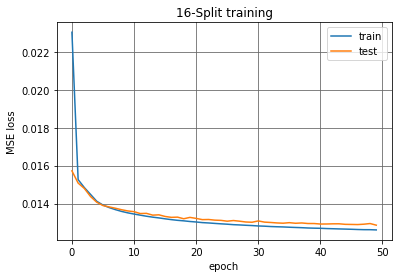

In [4]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

model.encoder.save_weights('../weights/42_CAE1x16_enc_epoch50_weights.h5')
model.decoder.save_weights('../weights/42_CAE1x16_dec_epoch50_weights.h5')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_out_loss'])
plt.plot(history.history['val_decoder_out_loss'])
plt.title('16-Split training')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.savefig('../img/47_PLOTS/16split_latent1_reco_loss.png', dpi=200)

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14
latent_dim = 16

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/50
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0172 - classifier_out_loss: 2.3245 - decoder_out_loss: 0.0172 - regressor_out_loss: 99.4051 - classifier_out_accuracy: 0.0978 - decoder_out_accuracy: 0.9515 - regressor_out_accuracy: 0.4813 - val_loss: 0.0044 - val_classifier_out_loss: 2.3082 - val_decoder_out_loss: 0.0044 - val_regressor_out_loss: 99.7702 - val_classifier_out_accuracy: 0.0964 - val_decoder_out_accuracy: 0.9524 - val_regressor_out_accuracy: 0.4749
Epoch 2/50
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0033 - classifier_out_loss: 2.3076 - decoder_out_loss: 0.0033 - regressor_out_loss: 99.7758 - classifier_out_accuracy: 0.0972 - decoder_out_accuracy: 0.9530 - regressor_out_accuracy: 0.4813 - val_loss: 0.0027 - val_classifier_out_loss: 2.3072 - val_decoder_out_loss: 0.0027 - val_regressor_out_loss: 99.7725 - val_classifier_out_accuracy: 0.0942 - val_decoder_out_accuracy: 0.9530 - val_regressor_out_accuracy: 0.4749
Epoc

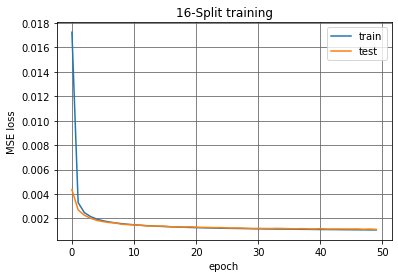

In [3]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.0,
    'regressor_out' : 0.0
}
model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=50, batch_size=32)

model.encoder.save_weights('../weights/42_CAE16x16_enc_epoch50_weights.h5')
model.decoder.save_weights('../weights/42_CAE16x16_dec_epoch50_weights.h5')

import matplotlib.pyplot as plt

plt.plot(history.history['decoder_out_loss'])
plt.plot(history.history['val_decoder_out_loss'])
plt.title('16-Split training')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.savefig('../img/47_PLOTS/16split_latent16_reco_loss.png', dpi=200)

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 6.9981 - val_loss: 2.9457
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 2.7707 - val_loss: 2.1771
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 2.1132 - val_loss: 1.9478
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7653 - val_loss: 1.7981
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6368 - val_loss: 1.9149
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.5499 - val_loss: 1.6765
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4620 - val_loss: 1.2935
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4602 - val_loss: 1.3092
Epoch 9/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4005 - val_loss: 1.3480
Epoch 10/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1.404

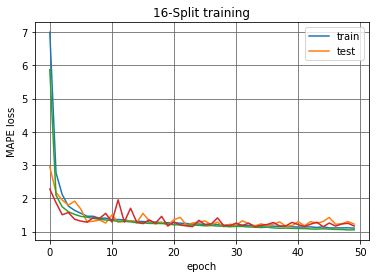

In [2]:
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

histories = []

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations

n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14

for latent_dim in [8,16]:
    

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_train = x_train.astype('float32') / 255.
    x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
    x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
    # y_train = keras.utils.to_categorical(y_train)

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_test = x_test.astype('float32') / 255.
    x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
    x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
    # y_test = keras.utils.to_categorical(y_test)
    
    model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

    history = model.fit(x_train_split, y_train_regr, validation_data=(x_test_split, y_test_regr), epochs=50, batch_size=32)

    model.encoder.save_weights('../weights/42_CAE%dx16_regr_enc_epoch50_weights.h5' % latent_dim)
    model.regressor.save_weights('../weights/42_CAE%dx16_regr_epoch50_weights.h5' % latent_dim)


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('16-Split training')
    plt.ylabel('MAPE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.savefig('../img/47_PLOTS/16split_latent%d_regr_loss.png' % latent_dim, dpi=200) 
    
    histories.append(history)
    model = None

In [16]:
print(histories[0].history['val_loss'][-1])

3.036241054534912


Epoch 1/50
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7790 - acc: 0.3161 - val_loss: 1.3875 - val_acc: 0.4712
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1892 - acc: 0.5587 - val_loss: 0.9970 - val_acc: 0.6289
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.9354 - acc: 0.6622 - val_loss: 0.8012 - val_acc: 0.7121
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8033 - acc: 0.7172 - val_loss: 0.7501 - val_acc: 0.7284
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7207 - acc: 0.7462 - val_loss: 0.6958 - val_acc: 0.7607
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6691 - acc: 0.7658 - val_loss: 0.6525 - val_acc: 0.7787
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6245 - acc: 0.7841 - val_loss: 0.6204 - val_acc: 0.7854
Epoch 8/50
1875/1875 [==============================] - 7s 4ms

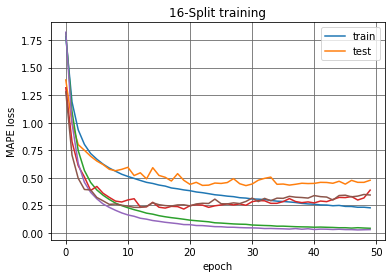

In [4]:
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

histories = []

def embed_and_translate(data, n_width, n_height):
    ndata = np.zeros((len(data), n_width, n_height, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(n_width-width)
        y = np.random.randint(n_height-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations

n_splits = 16
output_shape = (56, 56, 1)
input_shape  = (14, 14, 1)
split_x, split_y = 14, 14

for latent_dim in [2,8,16]:

    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_train = x_train.astype('float32') / 255.
    x_train_augmented, y_train_regr = embed_and_translate(x_train, output_shape[0], output_shape[1])
    x_train_split = np.array([utils.split(x, split_x, split_y) for x in x_train_augmented], dtype='float32')
    y_train = keras.utils.to_categorical(y_train)

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    x_test = x_test.astype('float32') / 255.
    x_test_augmented, y_test_regr = embed_and_translate(x_test, output_shape[0], output_shape[1])
    x_test_split = np.array([utils.split(x, split_x, split_y) for x in x_test_augmented], dtype='float32')
    y_test = keras.utils.to_categorical(y_test)
    
    model = MultiSplit(n_splits, latent_dim, input_shape, output_shape)
    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

    history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=50, batch_size=32)

    model.encoder.save_weights('../weights/42_CAE%dx16_classif_enc_epoch50_weights.h5' % latent_dim)
    model.classifier.save_weights('../weights/42_CAE%dx16_classif_epoch50_weights.h5' % latent_dim)


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('16-Split training')
    plt.ylabel('MAPE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.savefig('../img/47_PLOTS/16split_latent%d_classif_loss.png' % latent_dim, dpi=200) 
    
    histories.append(history)
    model = None

In [26]:
print(len(histories))
print(min(histories[-1].history['val_loss']))
print(max(histories[-1].history['val_acc']))

3
0.23257465660572052
0.9394999742507935


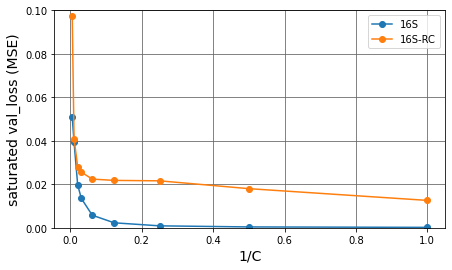

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# x = np.array([16/(28*28), 32/(28*28), 48/(28*28), 128/(28*28), 256/(28*28)])
a = (56*56)
b = 16
x = ([(b*1)/a, (b*2)/a, (b*4)/a, (b*6)/a, (b*12)/a, (b*24)/a, (b*49)/a, (b*98)/a, (b*196)/a])
# y = np.array([0.0509, 0.0394, 0.0226, 0.0110, 0.0045])
y = np.array([0.0509, 0.0394, 0.0197, 0.0135, 0.0058, 0.0023, 0.0009, 0.0004, 0.0002])
y_rc = np.array([0.0976, 0.0409, 0.0281, 0.0256, 0.0224, 0.0218, 0.0216, 0.0180, 0.0126])


plt.figure(figsize=(7,4))

plt.plot(x, y, 'o-')
plt.plot(x, y_rc, 'o-')
plt.xlabel("1/C", fontsize=14)
plt.legend(['16S', '16S-RC'])
plt.ylim([0,0.1])
plt.ylabel("saturated val_loss (MSE)", fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.savefig('../img/47_PLOTS/summary_MSE.png')

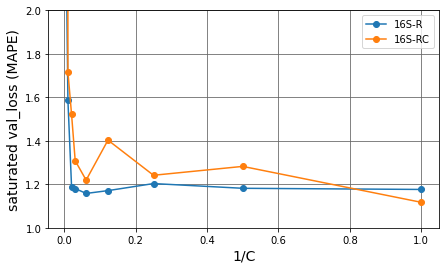

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = (56*56)
b = 16
x = ([(b*1)/a, (b*2)/a, (b*4)/a, (b*6)/a, (b*12)/a, (b*24)/a, (b*49)/a, (b*98)/a, (b*196)/a])

# x = np.array([16/(28*28), 32/(28*28), 48/(28*28), 128/(28*28), 256/(28*28)])
# y = np.array([0.8782, 0.4783, 0.3248, 0.2991, 0.2328])
y = np.array([2.3214, 1.5861, 1.1892, 1.1805, 1.1580, 1.1710, 1.2034, 1.1817, 1.1764])
y_rc = np.array([28.2130, 1.7168, 1.5217, 1.3084, 1.2194, 1.4032, 1.2416, 1.2824, 1.1173])


plt.figure(figsize=(7,4))

plt.plot(x, y, 'o-')
plt.plot(x, y_rc, 'o-')
plt.ylim([1,2.0])
plt.legend(['16S-R', '16S-RC'])
plt.xlabel("1/C", fontsize=14)
plt.ylabel("saturated val_loss (MAPE)", fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.savefig('../img/47_PLOTS/summary_MAPE.png')

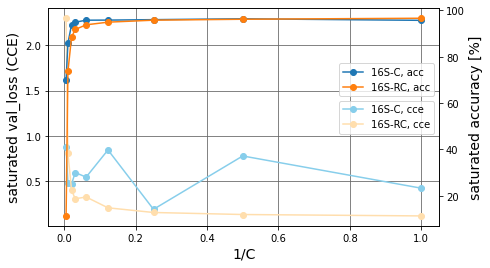

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# x = np.array([16, 32, 48, 128, 256])
# y = np.array([0.8782, 0.4783, 0.3248, 0.2991, 0.2328])
# y2 = np.array([70.15, 85.79, 92.66, 93.38, 93.94])
a = (56*56)
b = 16
x = ([(b*1)/a, (b*2)/a, (b*4)/a, (b*6)/a, (b*12)/a, (b*24)/a, (b*49)/a, (b*98)/a, (b*196)/a])

y = np.array([0.8782, 0.4783, 0.4653, 0.5932, 0.5422, 0.8431, 0.1859, 0.7766, 0.42])
y_class = np.array([70.15, 85.79, 93.88, 94.88, 95.76, 95.80, 95.99, 96.37, 95.7])
y_rc = np.array([2.3011, 0.8049, 0.3986, 0.3026, 0.3224, 0.2026, 0.1509, 0.1284, 0.1129])
y_rc_class = np.array([11.34, 73.68, 88.49, 91.75, 93.76, 94.91, 95.77, 96.17, 96.60])


fig, ax1 = plt.subplots(figsize=(7,4))

color = 'blue'
ax1.set_xlabel('1/C', fontsize=14)
ax1.set_ylabel('saturated val_loss (CCE)', fontsize=14)
ax1.plot(x, y, 'o-', color='skyblue')
ax1.plot(x, y_rc, 'o-', color='navajowhite')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('saturated accuracy [%]', fontsize=14)  # we already handled the x-label with ax1
ax2.plot(x, y_class, 'o-', color='tab:blue')
ax2.plot(x, y_rc_class, 'o-', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='black')

ax1.legend(['16S-C, cce', '16S-RC, cce'], loc='right')
ax2.legend(['16S-C, acc', '16S-RC, acc'], bbox_to_anchor=(1,0.77))

ax1.grid(b=True, which='major', color='#666666', linestyle='-')

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('../img/47_PLOTS/summary_CCE_acc.png')

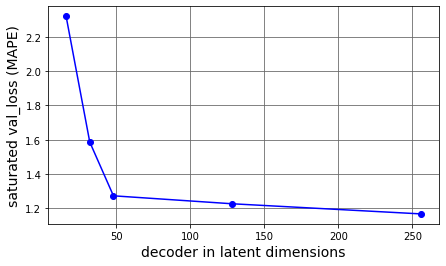

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([16, 32, 48, 128, 256])
y = np.array([2.3214, 1.5861, 1.2721, 1.2257, 1.1663])


plt.figure(figsize=(7,4))

plt.plot(x, y, 'bo-')
plt.xlabel("decoder in latent dimensions", fontsize=14)
plt.ylabel("saturated val_loss (MAPE)", fontsize=14)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.savefig('../img/47_PLOTS/summary_MAPE.png')